# **The Stable Diffusion Guide**


Since its public release the community has done an incredible job at working together to make the stable diffusion checkpoints **faster**, **more memory efficient**, and **more performant**.



### Setup

First, please make sure you are using a GPU runtime to run this notebook, so inference is much faster. If the following command fails, use the `Runtime` menu above and select `Change runtime type`.

In [1]:
!pip install --upgrade jax
!pip install --upgrade diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 MB 7.5 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.33
    Uninstalling jaxlib-0.4.33:
      Successfully uninstalled jaxlib-0.4.33
  Attempting uninstall: jax
    Found existing installation: jax 0.4.33
    Uninstalling jax-0.4.33:
      Successfully uninstalled jax-0.4.33


In [2]:
!nvidia-smi

Fri Dec  6 05:58:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Next, you should install `diffusers` as well `scipy`, `ftfy` and `transformers`.

In [3]:
model_id = "runwayml/stable-diffusion-v1-5"
from diffusers import StableDiffusionPipeline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Let's load the pipeline as defined on https://huggingface.co/runwayml/stable-diffusion-v1-5 .

## Speed Optimization

In [4]:
pipe = StableDiffusionPipeline.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

We aim at generating a beautiful photograph of an *old warrior chief* and will later try to find the best prompt to generate such a photograph. For now, let's keep the prompt simple:

In [5]:
prompt = "colored portrait photo of a old indian warrior with big mustache"

To begin with, we should make sure we run inference on GPU, so let's move the pipeline to GPU, just like you would with any PyTorch module.

In [6]:
pipe = pipe.to("cuda")

In [7]:
import torch

generator = torch.Generator("cuda").manual_seed(0)

Now, let's take a spin on it.

  0%|          | 0/50 [00:00<?, ?it/s]

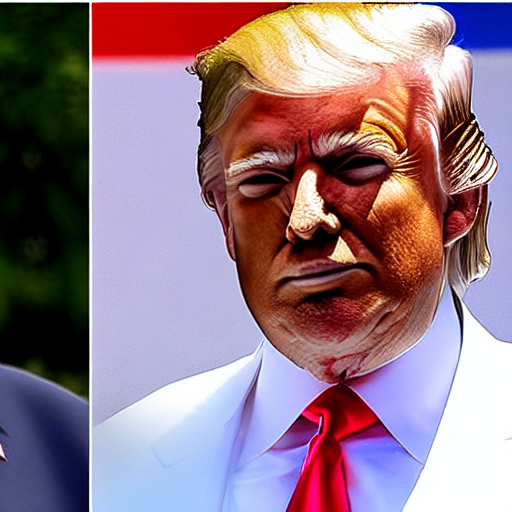

In [8]:
image = pipe(prompt, generator=generator).images[0]
image

In [9]:
prompt = "An image of a squirrel in Picasso style"

  0%|          | 0/50 [00:00<?, ?it/s]

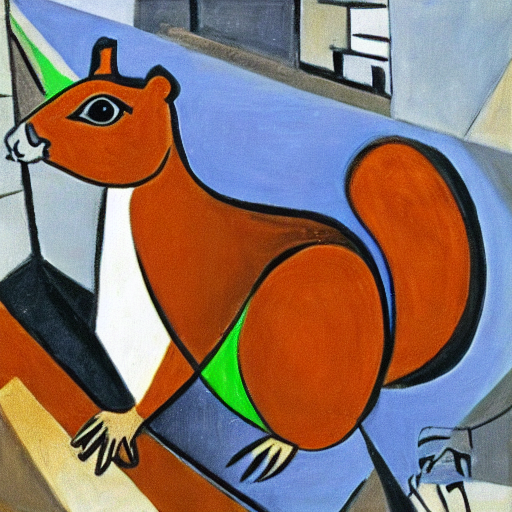

In [12]:
image = pipe(prompt, generator=generator).images[0]
image

Cool, this now took roughly 30 seconds on a T4 GPU (you might see faster inference if you're allocated GPU is better than a T4).

The default run we did above used full float32 precision and run the default 50 inference steps. The easiest speed-ups come from switiching to float16 (or half) precision and simply running less inference steps. Let's load the model now instead in float16.

In [13]:
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

And we can again call the pipeline to generate an image.

In [ ]:
prompt = "portrait photo of a old warrior chief"

  0%|          | 0/50 [00:00<?, ?it/s]

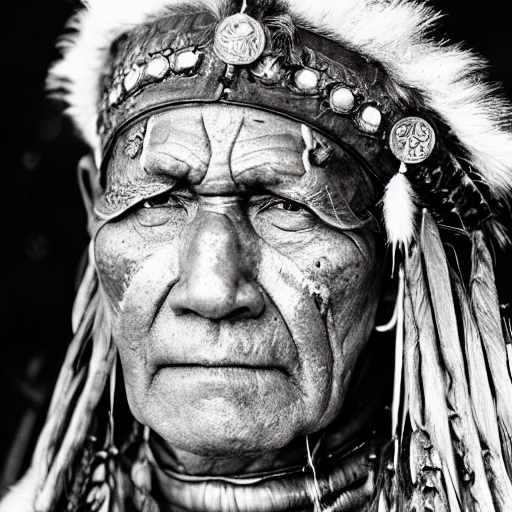

In [ ]:
generator = torch.Generator("cuda").manual_seed(0)

image = pipe(prompt, generator=generator).images[0]
image

Cool, this is almost three times as fast for arguably the exact same image quality.

We strongly suggest to always run your pipelines in float16 as so far we have very rarely seen degradations in quality because of it.

Next, let's see if we really need to use 50 inference steps or whether we could use significantly less.

Let's have a look at all schedulers, the stable diffusion pipeline is compatible with.

In [14]:
pipe.scheduler.compatibles

[diffusers.schedulers.scheduling_lms_discrete.LMSDiscreteScheduler,
 diffusers.schedulers.scheduling_deis_multistep.DEISMultistepScheduler,
 diffusers.schedulers.scheduling_heun_discrete.HeunDiscreteScheduler,
 diffusers.schedulers.scheduling_k_dpm_2_ancestral_discrete.KDPM2AncestralDiscreteScheduler,
 diffusers.schedulers.scheduling_euler_ancestral_discrete.EulerAncestralDiscreteScheduler,
 diffusers.schedulers.scheduling_k_dpm_2_discrete.KDPM2DiscreteScheduler,
 diffusers.schedulers.scheduling_edm_euler.EDMEulerScheduler,
 diffusers.schedulers.scheduling_dpmsolver_singlestep.DPMSolverSinglestepScheduler,
 diffusers.schedulers.scheduling_pndm.PNDMScheduler,
 diffusers.utils.dummy_torch_and_torchsde_objects.DPMSolverSDEScheduler,
 diffusers.schedulers.scheduling_euler_discrete.EulerDiscreteScheduler,
 diffusers.schedulers.scheduling_unipc_multistep.UniPCMultistepScheduler,
 diffusers.schedulers.scheduling_dpmsolver_multistep.DPMSolverMultistepScheduler,
 diffusers.schedulers.scheduling

In [15]:
from diffusers import DPMSolverMultistepScheduler

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

Now, let's try to reduce the number of inference steps to just 20.

  0%|          | 0/20 [00:00<?, ?it/s]

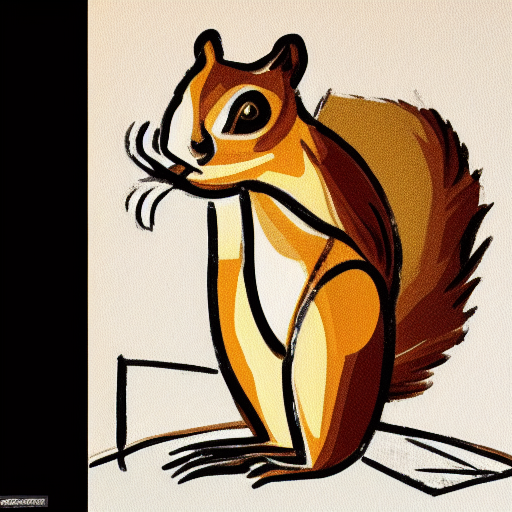

In [16]:
generator = torch.Generator("cuda").manual_seed(0)

image = pipe(prompt, generator=generator, num_inference_steps=20).images[0]
image

The image now does look a little different, but it's arguably still of equally high quality. We now cut inference time to just 4 seconds though .

## Memory Optimization

More memory indirectly also means more speed since we're often trying to maximize how many images we can generate per second, so more images per inference, more images per second usually.

The easiest way to see how much we can increase memory is to simply try it out, and see when we get a *"Out-of-memory (OOM)"* error.

One can run batched inference by simply passing a list of prompts and generators. Let's define a quick function that generates a batch for us.

In [17]:
def get_inputs(batch_size=1):
  generator = [torch.Generator("cuda").manual_seed(i) for i in range(batch_size)]
  prompts = batch_size * [prompt]
  num_inference_steps = 20

  return {"prompt": prompts, "generator": generator, "num_inference_steps": num_inference_steps}

We also need a method that allows us to easily display a batch of images.

In [18]:
from PIL import Image

def image_grid(imgs, rows=2, cols=2):
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

Cool, let's see how much memory we can use starting with batch_size=4.

In [19]:
images = pipe(**get_inputs(batch_size=6)).images
image_grid(images)

Output hidden; open in https://colab.research.google.com to view.

Great now that attention slicing is enabled, let's try to double the batch size again, going for `batch_size=8`.

In [20]:
pipe.enable_attention_slicing()

In [21]:
images = pipe(**get_inputs(batch_size=8)).images
image_grid(images, rows=2, cols=4)

Output hidden; open in https://colab.research.google.com to view.

## Quality Improvements

Now that our image generation pipeline is blazing fast, let's try to get maximum image quality.

First of all, image quality is extremely subjective, so it's difficult to make general claims here.

The most obvious step to take to improve quality is to use *better checkpoints*. Since the release of Stable Diffusion many improved versions have been released, which are summarized here:

- *Official Release - 22 Aug 2022*: [Stable-Diffusion 1.4](https://huggingface.co/CompVis/stable-diffusion-v1-4)
- *20 October 2022*: [Stable-Diffusion 1.5](https://huggingface.co/runwayml/stable-diffusion-v1-5)
- *24 Nov 2022*: [Stable-Diffusion 2.0](https://huggingface.co/stabilityai/stable-diffusion-2-0)
- *7 Dec 2022*: [Stable-Diffusion 2.1](https://huggingface.co/stabilityai/stable-diffusion-2-1)

Newer versions don't necessarily mean better image quality with the same parameters. People mentioned that *2.0* is slighly worse than *1.5* for certain prompts, but given the right prompt engineering *2.0* and *2.1* seem to be better.

Overall, we strongly recommend to just try the models out and read up on advice online $^{2}$

Additionally, the community has started fine-tuning many of the above versions on certain styles with some of them having an extremely high quality and gaining a lot of traction.




In [22]:
from diffusers import AutoencoderKL

vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16).to("cuda")

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Now we can set it to the vae of the pipeline to use it.

In [23]:
pipe.vae = vae

Let's run the same prompt as before to compare quality.

In [24]:
images = pipe(**get_inputs(batch_size=11)).images
image_grid(images, rows=3, cols=4)

Output hidden; open in https://colab.research.google.com to view.

Seems like the difference is only very minor, but the new generations are arguably a bit *sharper*.

Cool, finally, let's look a bit into prompt engineering.

Our goal was to generate a photo of an old warrior chief. Let's now try to bring a bit more color into the photos and make the look more impressive.

Originally our prompt was "*portrait photo of a old warrior chief*".

To improve the prompt, it often helps to add cues that could have been used online to save high quality photos, as well as adding more details since.
Essentially, when doing prompt engineering, one has to think:
- How was the photo or similar photos of the one I want probably stored on the internet?
- What additional detail can I give that steers the models into the style that I want.

Cool, let's add more details.

In [25]:
prompt += "Donald trump visit mumbai street"

and let's also add some cues that usually help to generate higher quality images.

In [ ]:
prompt += " 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta"
prompt

'portrait photo of a old warrior chief 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta, tribal panther make up, blue on red, side profile, looking away, serious eyes 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta'

Cool, let's now try this prompt.

In [ ]:
images = pipe(**get_inputs(batch_size=8)).images
image_grid(images, rows=2, cols=4)

Pretty impressive! We got definitely some very high quality image generations there. The 2nd image is my personal favorite, so I'll re-use this seed and see whether I can tweak the prompts slighly by using "oldest warrior", "old", "", and "young" instead of "old".

In [ ]:
prompts = [
    "portrait photo of the oldest warrior chief, tribal panther make up, blue on red, side profile, looking away, serious eyes 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta",
    "portrait photo of a old warrior chief, tribal panther make up, blue on red, side profile, looking away, serious eyes 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta",
    "portrait photo of a warrior chief, tribal panther make up, blue on red, side profile, looking away, serious eyes 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta",
    "portrait photo of a young warrior chief, tribal panther make up, blue on red, side profile, looking away, serious eyes 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta",
]

generator = [torch.Generator("cuda").manual_seed(1) for _ in range(len(prompts))]  # 1 because we want the 2nd image

images = pipe(prompt=prompts, generator=generator, num_inference_steps=25).images
image_grid(images)

The first picture looks nice! The eye movement slighly changed and looks nice. This finished up our guide on how to use Stable Diffusion.

